# New York City Crime

<img src=images/banner.jpg/ width="600">

# Overview

# Business Understanding

New York City crime has gone through cycles. After the 2020 pandemic, many spoke about the increase in crime and the lack of enforcement against criminal behavior. The New York City Police Department (NYPD) is the largest and one of the oldest municipal police departments in the United States. The NYPD polices a city of approximately 8.5 million people. The purpose of this project is to **assist the NYPD keep crime levels low** through machine learning. I will do this **by creating a time series model to predict crime in New York City**. 

The stakeholders for this project include the New York City Police Commissioner and the Board of Commissioners. With an understanding of crime trends and future crime predictions, the executive staff can determine a future plan for officers to prevent future crime or stop future crime as soon as possible.

In this project, I will complete the following 3 tasks:
1. **Analyze** crime trends in historical New York City crime data.
2. Create a time series model to **predict** future crime in New York city.
3. **Evaluate** the time series model and recommend next steps for the New York City Police Department.

# Data Understanding

The [data](https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data) has been extracted from NYC Open Data. It includes all valid felony, misdemeanor, and violation crimes reported to the New York City Police Department (NYPD) from 2006 to the end of 2023. There are 8,914,838 complaints reported. The data has 35 columns with reported information regarding each incident. The column descriptions can be found on the (data page)[https://data.cityofnewyork.us/Public-Safety/NYPD-Complaint-Data-Historic/qgea-i56i/about_data]. 



First I will import all the necessary libraries for EDA, data cleaning and modeling.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import random

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX

random.seed(28)

In [2]:
# Import NYPD crime data and preview the first 5 rows to ensure it was imported correctly
data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')
data.head()

/var/folders/pn/v9tvzf9s5ms7zcp53821ct0m0000gn/T/ipykernel_46275/1856452097.py:2: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('data/NYPD_Complaint_Data_Historic_20241022.csv')


,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
0,25640826H10611,12/05/2006,10:38:00,NaN,(null),NaN,12/05/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO QUEENS NORTH,(null),25-44,WHITE HISPANIC,M
1,16631501H8965,08/25/1973,12:15:00,NaN,(null),NaN,05/29/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO MAN NORTH,(null),45-64,BLACK,F
2,11118212H8714,04/22/2006,16:50:00,NaN,(null),NaN,04/22/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),45-64,BLACK,M
3,23471265H9399,07/20/2006,22:37:00,NaN,(null),NaN,07/20/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,M
4,24565927H10142,04/14/2006,02:37:00,NaN,(null),NaN,04/14/2006,101,MURDER & NON-NEGL. MANSLAUGHTER,NaN,...,(null),NaN,NaN,NaN,NaN,PATROL BORO BKLYN NORTH,(null),45-64,BLACK,M


# Data Preparation

## Exploratory Data Analysis

In [3]:
# View the overall shape, dtypes and null counts for each column in train data
data.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914838 entries, 0 to 8914837
Data columns (total 35 columns):
 #   Column             Non-Null Count    Dtype  
---  ------             --------------    -----  
 0   CMPLNT_NUM         8914838 non-null  object 
 1   CMPLNT_FR_DT       8914183 non-null  object 
 2   CMPLNT_FR_TM       8914838 non-null  object 
 3   CMPLNT_TO_DT       7095880 non-null  object 
 4   CMPLNT_TO_TM       8914838 non-null  object 
 5   ADDR_PCT_CD        8914067 non-null  float64
 6   RPT_DT             8914838 non-null  object 
 7   KY_CD              8914838 non-null  int64  
 8   OFNS_DESC          8914838 non-null  object 
 9   PD_CD              8907245 non-null  float64
 10  PD_DESC            8914838 non-null  object 
 11  CRM_ATPT_CPTD_CD   8914838 non-null  object 
 12  LAW_CAT_CD         8914838 non-null  object 
 13  BORO_NM            8914838 non-null  object 
 14  LOC_OF_OCCUR_DESC  8914604 non-null  object 
 15  PREM_TYP_DESC      8914838 non-n

In [4]:
# Convert 'CMPLNT_NUM' to string
data['CMPLNT_NUM'] = data['CMPLNT_NUM'].astype(str)

In [5]:
# Check for duplicated using 'CMPLNT_NUM'
data['CMPLNT_NUM'].duplicated().value_counts()

CMPLNT_NUM
False    8913734
True        1104
Name: count, dtype: int64

In [6]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM', axis=0)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
239715,9966585,01/02/2005,16:30:00,NaN,(null),70.0,01/02/2006,109,GRAND LARCENY,421.0,...,(null),NaN,40.642402,-73.959552,"(40.642402, -73.959552)",PATROL BORO BKLYN SOUTH,(null),25-44,BLACK,F
124876,9966658,01/04/2006,15:30:00,01/05/2006,09:30:00,72.0,01/05/2006,341,PETIT LARCENY,321.0,...,(null),NaN,40.661648,-73.981201,"(40.661648, -73.981201)",PATROL BORO BKLYN SOUTH,(null),45-64,WHITE,M
378931,9966757,12/15/2005,11:00:00,NaN,(null),75.0,01/03/2006,353,UNAUTHORIZED USE OF A VEHICLE,462.0,...,M,NaN,40.671360,-73.881811,"(40.6713598203364, -73.8818110231735)",PATROL BORO BKLYN NORTH,(null),18-24,BLACK,F
48564,9966791,01/04/2006,08:55:00,01/04/2006,09:00:00,76.0,01/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,(null),NaN,40.683651,-74.000304,"(40.6836512406856, -74.0003043120176)",PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,F


In [7]:
data[data['CMPLNT_NUM'].duplicated() == True].sort_values('CMPLNT_NUM').head(20)

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,SUSP_SEX,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX
466739,10007381,01/04/2006,07:45:00,01/04/2006,07:47:00,107.0,01/04/2006,109,GRAND LARCENY,438.0,...,M,NaN,40.730113,-73.810909,"(40.7301130668694, -73.8109089148815)",PATROL BORO QUEENS SOUTH,(null),25-44,WHITE HISPANIC,F
249295,10008294,01/01/2006,16:30:00,01/01/2006,16:35:00,63.0,01/01/2006,578,HARRASSMENT 2,637.0,...,(null),NaN,40.612661,-73.912395,"(40.612661, -73.912395)",PATROL BORO BKLYN SOUTH,(null),25-44,ASIAN / PACIFIC ISLANDER,M
226425,10008686,07/23/2004,00:01:00,08/16/2005,00:01:00,77.0,01/06/2006,112,THEFT-FRAUD,489.0,...,(null),NaN,40.668438,-73.924120,"(40.668438, -73.92412)",PATROL BORO BKLYN NORTH,(null),25-44,BLACK,F
92052,10012321,01/03/2006,22:00:00,NaN,(null),62.0,01/03/2006,106,FELONY ASSAULT,109.0,...,M,NaN,40.614331,-73.979106,"(40.614331, -73.979106)",PATROL BORO BKLYN SOUTH,(null),25-44,WHITE,F
337659,10012366,12/23/2005,10:30:00,NaN,(null),63.0,01/03/2006,109,GRAND LARCENY,415.0,...,(null),NaN,40.627544,-73.937954,"(40.627544, -73.937954)",PATROL BORO BKLYN SOUTH,(null),65+,BLACK,F
515607,10015119,01/05/2006,20:30:00,01/07/2006,02:00:00,45.0,01/07/2006,107,BURGLARY,224.0,...,(null),NaN,40.824741,-73.821517,"(40.824741, -73.821517)",PATROL BORO BRONX,(null),25-44,WHITE HISPANIC,F
358705,10015262,01/04/2006,16:48:00,01/04/2006,16:48:00,49.0,01/04/2006,236,DANGEROUS WEAPONS,782.0,...,(null),NaN,40.856577,-73.843894,"(40.8565767275976, -73.8438936779283)",PATROL BORO BRONX,(null),(null),UNKNOWN,E
467185,10015321,01/03/2006,18:00:00,01/03/2006,19:00:00,50.0,01/03/2006,344,ASSAULT 3 & RELATED OFFENSES,101.0,...,M,NaN,40.882862,-73.903574,"(40.8828621313214, -73.9035744897024)",PATROL BORO BRONX,(null),65+,WHITE,F
489184,10015453,01/07/2006,21:46:00,01/07/2006,21:56:00,115.0,01/07/2006,113,FORGERY,723.0,...,(null),NaN,40.756568,-73.875932,"(40.7565675846374, -73.8759315341335)",PATROL BORO QUEENS NORTH,(null),(null),UNKNOWN,E
467859,10016512,01/04/2006,10:00:00,01/04/2006,23:00:00,113.0,01/05/2006,110,GRAND LARCENY OF MOTOR VEHICLE,441.0,...,(null),NaN,40.674323,-73.789208,"(40.674323, -73.789208)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,F


In [8]:
# View year range of data
## TO DO

In [9]:
data['LAW_CAT_CD'].value_counts().index[1]

'FELONY'

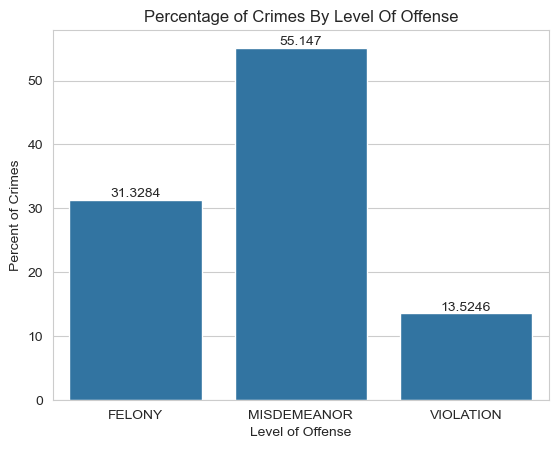

In [10]:
# Visualize crimes by level of offense
ax = sns.countplot(x="LAW_CAT_CD", data=data, stat='percent')
ax.set_xlabel('Level of Offense')
ax.set_ylabel('Percent of Crimes')
ax.set_title('Percentage of Crimes By Level Of Offense')
ax.bar_label(ax.containers[0]);

In [11]:
# View the different types of crime descriptions
data['OFNS_DESC'].value_counts()

OFNS_DESC
PETIT LARCENY                      1556946
HARRASSMENT 2                      1187346
ASSAULT 3 & RELATED OFFENSES        935330
CRIMINAL MISCHIEF & RELATED OF      876668
GRAND LARCENY                       783519
                                    ...   
FORTUNE TELLING                         13
ABORTION                                 7
OFFENSES AGAINST MARRIAGE UNCL           5
UNDER THE INFLUENCE OF DRUGS             3
KIDNAPPING AND RELATED OFFENSES          3
Name: count, Length: 73, dtype: int64

In [12]:
top_10_off_desc = data.groupby('OFNS_DESC').size().sort_values(ascending=False).head(10)

In [13]:
top_10_off_desc

OFNS_DESC
PETIT LARCENY                     1556946
HARRASSMENT 2                     1187346
ASSAULT 3 & RELATED OFFENSES       935330
CRIMINAL MISCHIEF & RELATED OF     876668
GRAND LARCENY                      783519
DANGEROUS DRUGS                    456550
OFF. AGNST PUB ORD SENSBLTY &      436929
FELONY ASSAULT                     363917
ROBBERY                            314941
BURGLARY                           297225
dtype: int64

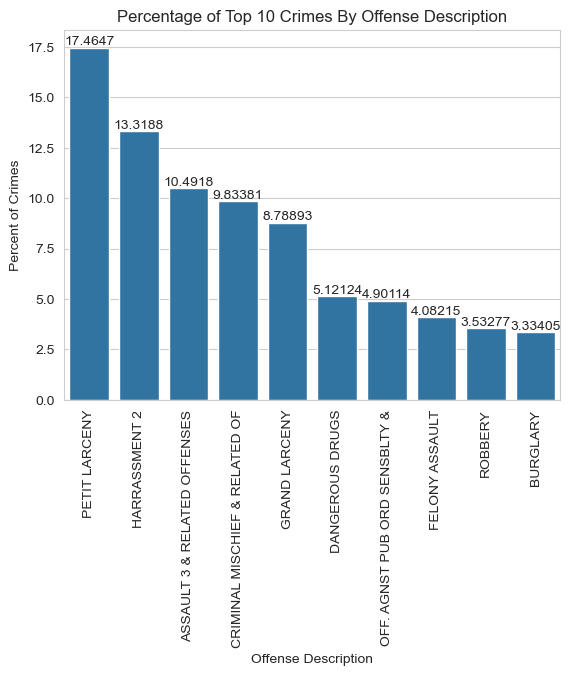

In [14]:
# Visualize crimes by offense description
ax = sns.countplot(data=data, 
                   x='OFNS_DESC', 
                   stat='percent',
                  order=data['OFNS_DESC'].value_counts(ascending=False).iloc[:10].index)
ax.set_xlabel('Offense Description')
plt.xticks(rotation=90)
ax.set_ylabel('Percent of Crimes')
ax.set_title('Percentage of Top 10 Crimes By Offense Description')
ax.bar_label(ax.containers[0]);

In [15]:
data.index

RangeIndex(start=0, stop=8914838, step=1)

In [16]:
data['CMPLNT_FR_DT'].value_counts()

CMPLNT_FR_DT
01/01/2010    2515
01/01/2016    2440
01/01/2014    2433
01/01/2011    2395
01/01/2008    2371
              ... 
10/30/1970       1
05/09/1988       1
08/29/1982       1
08/02/2003       1
11/06/1993       1
Name: count, Length: 9949, dtype: int64

In [17]:
data['CMPLNT_FR_DT'][0][-4:]

'2006'

In [18]:
# Create column with year of complaint
data['Year'] = data['CMPLNT_FR_DT'].apply(lambda x: str(x)[-4:])

In [19]:
data[data['Year'] == 'nan']

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year
6455,11053532,NaN,03:45:00,04/23/2006,04:50:00,122.0,04/23/2006,341,PETIT LARCENY,321.0,...,NaN,40.558768,-74.169395,"(40.558768, -74.169395)",PATROL BORO STATEN ISLAND,(null),18-24,WHITE,M,nan
7606,10919210,NaN,09:00:00,NaN,(null),120.0,04/04/2006,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,NaN,40.636810,-74.118650,"(40.63681, -74.11865)",PATROL BORO STATEN ISLAND,(null),18-24,WHITE HISPANIC,F,nan
13170,26098474,NaN,11:30:00,12/24/2006,12:20:00,120.0,12/24/2006,344,ASSAULT 3 & RELATED OFFENSES,113.0,...,NaN,40.614774,-74.083046,"(40.614774, -74.083046)",PATROL BORO STATEN ISLAND,(null),25-44,BLACK,M,nan
14046,10373963,NaN,09:02:00,NaN,(null),68.0,02/10/2006,578,HARRASSMENT 2,637.0,...,NaN,40.640211,-74.029741,"(40.640211, -74.029741)",PATROL BORO BKLYN SOUTH,(null),(null),UNKNOWN,M,nan
17850,25293635,NaN,13:39:00,NaN,(null),68.0,11/10/2006,106,FELONY ASSAULT,109.0,...,NaN,40.627488,-74.013928,"(40.627488, -74.013928)",PATROL BORO BKLYN SOUTH,(null),18-24,BLACK,M,nan
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4950009,145973350,NaN,09:00:00,NaN,(null),113.0,09/08/2015,109,GRAND LARCENY,424.0,...,NaN,40.682759,-73.767869,"(40.682759, -73.767869)",PATROL BORO QUEENS SOUTH,(null),25-44,BLACK,F,nan
4956791,144674119,NaN,19:10:00,07/20/2015,19:35:00,32.0,07/20/2015,578,HARRASSMENT 2,638.0,...,NaN,40.816002,-73.941332,"(40.816002, -73.941332)",PATROL BORO MAN NORTH,(null),25-44,BLACK,M,nan
4976132,145227904,NaN,19:30:00,NaN,(null),109.0,08/10/2015,361,OFF. AGNST PUB ORD SENSBLTY &,639.0,...,NaN,40.777608,-73.844347,"(40.777608, -73.844347)",PATROL BORO QUEENS NORTH,(null),25-44,WHITE HISPANIC,F,nan
5040256,143504462,NaN,13:30:00,06/06/2015,13:35:00,75.0,06/06/2015,578,HARRASSMENT 2,638.0,...,NaN,40.674375,-73.883560,"(40.674375, -73.88356)",PATROL BORO BKLYN NORTH,(null),18-24,ASIAN / PACIFIC ISLANDER,M,nan


In [20]:
# Drop rows where 'Year' is equal to 'nan'
data = data[data['Year'] != 'nan']

# Convert 'Year' to integer
data['Year'] = data['Year'].apply(lambda x: int(x))

In [21]:
# Keep entries only of year 2006 and later
data = data[data['Year']>=2006]

In [22]:
data['Year'].value_counts()

Year
2023    543331
2007    535486
2006    530194
2022    529839
2008    528967
2009    511230
2010    510377
2012    505058
2011    498927
2013    496223
2014    492395
2015    479035
2016    478625
2017    468368
2018    462719
2019    459296
2021    449571
2020    413812
Name: count, dtype: int64

In [23]:
# Create and set datetime object
data['CMPLNT_FR_DT'] = pd.to_datetime(data['CMPLNT_FR_DT'], format='%m/%d/%Y')

In [24]:
# Set index as datetime
data = data.set_index(data['CMPLNT_FR_DT'], drop=True).sort_index()
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,TRANSIT_DISTRICT,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2006-01-01,10282283,2006-01-01,20:00:00,01/02/2006,10:00:00,88.0,02/02/2006,365,ADMINISTRATIVE CODE,878.0,...,NaN,40.689525,-73.970637,"(40.689525, -73.970637)",PATROL BORO BKLYN NORTH,(null),(null),UNKNOWN,F,2006
2006-01-01,24505273,2006-01-01,12:00:00,NaN,(null),79.0,09/24/2006,109,GRAND LARCENY,439.0,...,NaN,40.692251,-73.950262,"(40.692251, -73.950262)",PATROL BORO BKLYN NORTH,(null),18-24,WHITE HISPANIC,M,2006
2006-01-01,23540679,2006-01-01,16:00:00,07/21/2006,18:00:00,115.0,07/21/2006,109,GRAND LARCENY,401.0,...,NaN,40.754744,-73.884272,"(40.754744, -73.884272)",PATROL BORO QUEENS NORTH,(null),18-24,ASIAN / PACIFIC ISLANDER,F,2006
2006-01-01,9965998,2006-01-01,04:30:00,NaN,(null),48.0,01/01/2006,351,CRIMINAL MISCHIEF & RELATED OF,259.0,...,NaN,40.857061,-73.883260,"(40.857061, -73.88326)",PATROL BORO BRONX,(null),65+,WHITE,M,2006
2006-01-01,88838140,2006-01-01,10:00:00,12/03/2008,23:00:00,72.0,01/26/2013,112,THEFT-FRAUD,739.0,...,NaN,40.645229,-74.012031,"(40.645229, -74.012031)",PATROL BORO BKLYN SOUTH,(null),65+,WHITE,F,2006


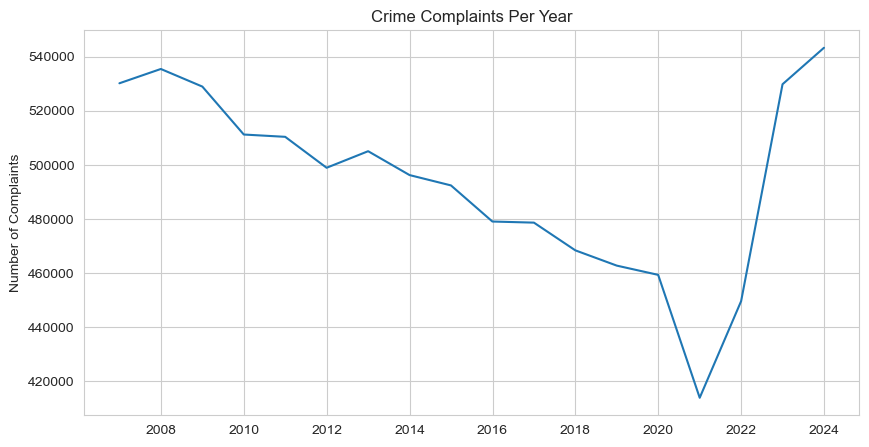

In [25]:
# Resample data to yearly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_yearly = data.resample('YE').count()['CMPLNT_FR_DT']
ax.plot(data_yearly.index, data_yearly.values)
ax.set_title('Crime Complaints Per Year')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above time plot

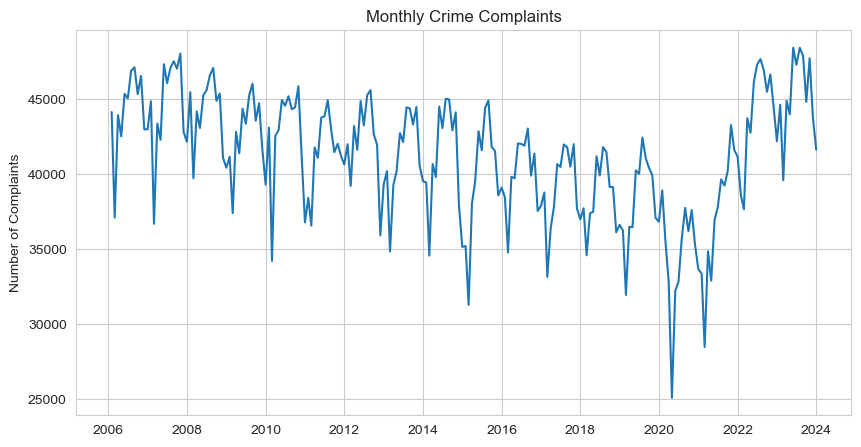

In [26]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(10, 5))
data_monthly = data.resample('ME').count()['CMPLNT_FR_DT']
ax.plot(data_monthly.index, data_monthly.values)
ax.set_title('Monthly Crime Complaints')
ax.set_ylabel('Number of Complaints');

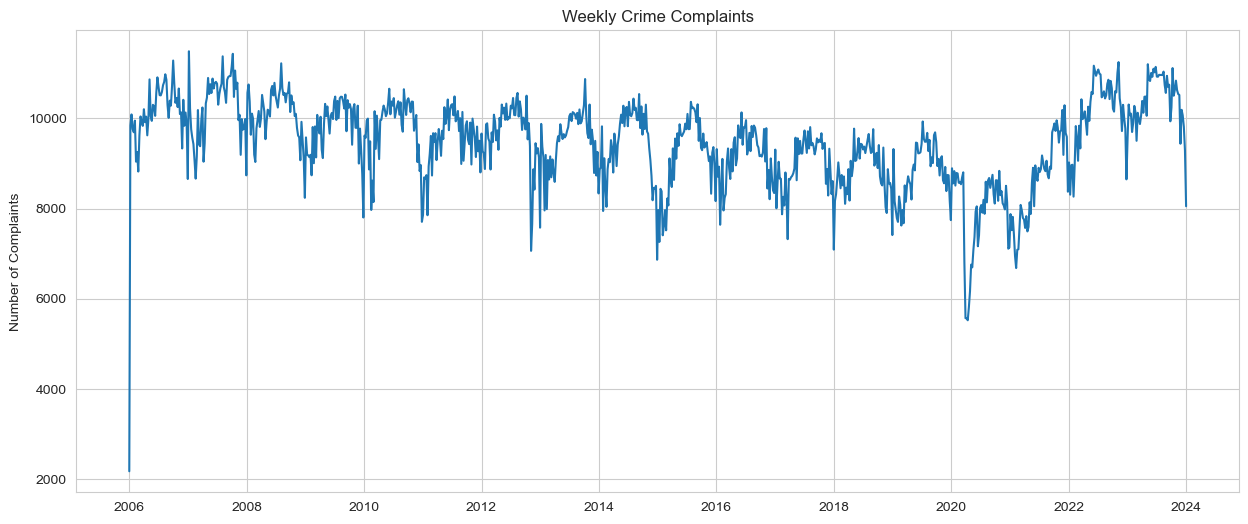

In [27]:
# Resample data to weekly and plot time series
fig, ax = plt.subplots(figsize=(15, 6))
data_weekly = data.resample('W').count()['CMPLNT_FR_DT']
ax.plot(data_weekly.index, data_weekly.values)
ax.set_title('Weekly Crime Complaints')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above time plot

In [94]:
data.index

DatetimeIndex(['2006-01-01', '2006-01-01', '2006-01-01', '2006-01-01',
               '2006-01-01', '2006-01-01', '2006-01-01', '2006-01-01',
               '2006-01-01', '2006-01-01',
               ...
               '2023-12-31', '2023-12-31', '2023-12-31', '2023-12-31',
               '2023-12-31', '2023-12-31', '2023-12-31', '2023-12-31',
               '2023-12-31', '2023-12-31'],
              dtype='datetime64[ns]', name='CMPLNT_FR_DT', length=8893453, freq=None)

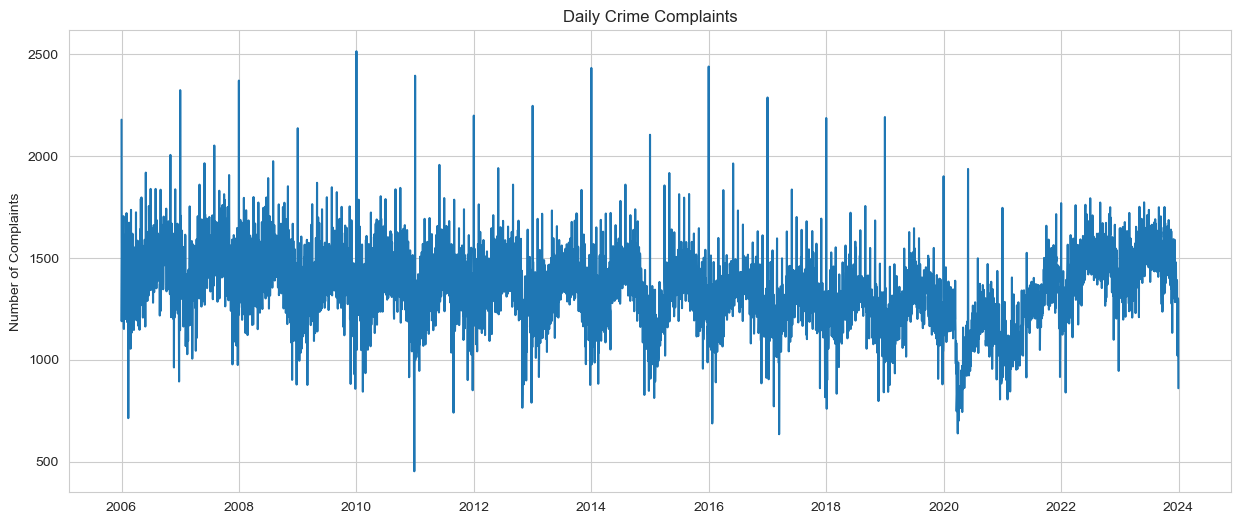

In [95]:
# Resample data to daily and plot time series
fig, ax = plt.subplots(figsize=(15, 6))
data_daily = data.resample('D').count()['CMPLNT_FR_DT']
ax.plot(data_daily.index, data_daily.values)
ax.set_title('Daily Crime Complaints')
ax.set_ylabel('Number of Complaints');

In [28]:
# Create column to sort complaints by month
data['Month'] = data.index.month
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Latitude,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year,Month
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2006-01-01,10282283,2006-01-01,20:00:00,01/02/2006,10:00:00,88.0,02/02/2006,365,ADMINISTRATIVE CODE,878.0,...,40.689525,-73.970637,"(40.689525, -73.970637)",PATROL BORO BKLYN NORTH,(null),(null),UNKNOWN,F,2006,1
2006-01-01,24505273,2006-01-01,12:00:00,NaN,(null),79.0,09/24/2006,109,GRAND LARCENY,439.0,...,40.692251,-73.950262,"(40.692251, -73.950262)",PATROL BORO BKLYN NORTH,(null),18-24,WHITE HISPANIC,M,2006,1
2006-01-01,23540679,2006-01-01,16:00:00,07/21/2006,18:00:00,115.0,07/21/2006,109,GRAND LARCENY,401.0,...,40.754744,-73.884272,"(40.754744, -73.884272)",PATROL BORO QUEENS NORTH,(null),18-24,ASIAN / PACIFIC ISLANDER,F,2006,1
2006-01-01,9965998,2006-01-01,04:30:00,NaN,(null),48.0,01/01/2006,351,CRIMINAL MISCHIEF & RELATED OF,259.0,...,40.857061,-73.883260,"(40.857061, -73.88326)",PATROL BORO BRONX,(null),65+,WHITE,M,2006,1
2006-01-01,88838140,2006-01-01,10:00:00,12/03/2008,23:00:00,72.0,01/26/2013,112,THEFT-FRAUD,739.0,...,40.645229,-74.012031,"(40.645229, -74.012031)",PATROL BORO BKLYN SOUTH,(null),65+,WHITE,F,2006,1


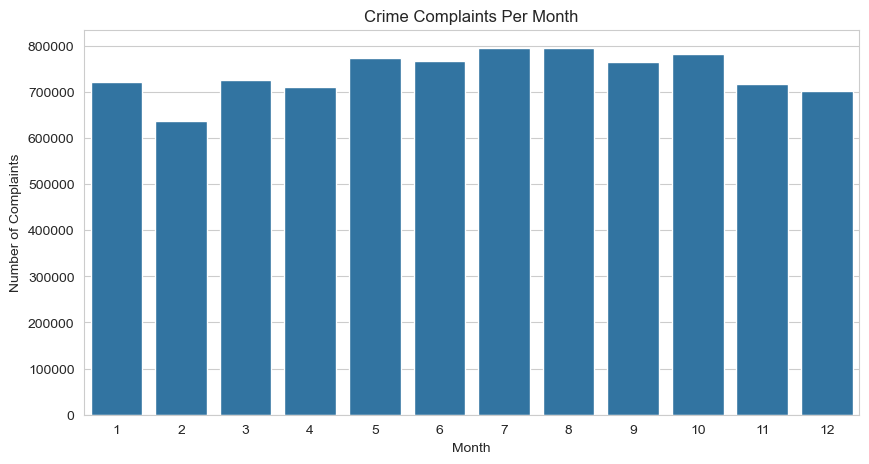

In [29]:
# Plot bar chart of number of complaints per month

x = data['Month'].value_counts().index
y = data['Month'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Month')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

In [30]:
data.index[0]

Timestamp('2006-01-01 00:00:00')

In [31]:
data.index[0].weekday

<bound method Timestamp.weekday of Timestamp('2006-01-01 00:00:00')>

In [32]:
# Create column to sort complaints by weekday
data['Weekday'] = data.index.weekday
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Longitude,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year,Month,Weekday
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2006-01-01,10282283,2006-01-01,20:00:00,01/02/2006,10:00:00,88.0,02/02/2006,365,ADMINISTRATIVE CODE,878.0,...,-73.970637,"(40.689525, -73.970637)",PATROL BORO BKLYN NORTH,(null),(null),UNKNOWN,F,2006,1,6
2006-01-01,24505273,2006-01-01,12:00:00,NaN,(null),79.0,09/24/2006,109,GRAND LARCENY,439.0,...,-73.950262,"(40.692251, -73.950262)",PATROL BORO BKLYN NORTH,(null),18-24,WHITE HISPANIC,M,2006,1,6
2006-01-01,23540679,2006-01-01,16:00:00,07/21/2006,18:00:00,115.0,07/21/2006,109,GRAND LARCENY,401.0,...,-73.884272,"(40.754744, -73.884272)",PATROL BORO QUEENS NORTH,(null),18-24,ASIAN / PACIFIC ISLANDER,F,2006,1,6
2006-01-01,9965998,2006-01-01,04:30:00,NaN,(null),48.0,01/01/2006,351,CRIMINAL MISCHIEF & RELATED OF,259.0,...,-73.883260,"(40.857061, -73.88326)",PATROL BORO BRONX,(null),65+,WHITE,M,2006,1,6
2006-01-01,88838140,2006-01-01,10:00:00,12/03/2008,23:00:00,72.0,01/26/2013,112,THEFT-FRAUD,739.0,...,-74.012031,"(40.645229, -74.012031)",PATROL BORO BKLYN SOUTH,(null),65+,WHITE,F,2006,1,6


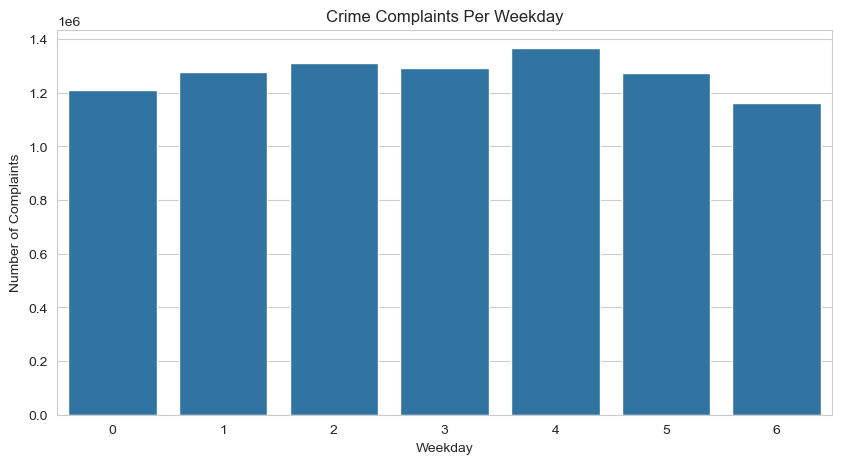

In [33]:
# Plot bar chart of number of complaints per weekday

x = data['Weekday'].value_counts().index
y = data['Weekday'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y, order=x.sort_values())
ax.set_title('Crime Complaints Per Weekday')
ax.set_ylabel('Number of Complaints');

In [34]:
# Create column to sort complaints by hour of occurence
data['Hour'] = data['CMPLNT_FR_TM']
data['Hour'] = data['Hour'].apply(lambda x: x[:2])
#data_sample['Month'] = data_sample['Month'].apply(lambda x: x.month)
data.head()

,CMPLNT_NUM,CMPLNT_FR_DT,CMPLNT_FR_TM,CMPLNT_TO_DT,CMPLNT_TO_TM,ADDR_PCT_CD,RPT_DT,KY_CD,OFNS_DESC,PD_CD,...,Lat_Lon,PATROL_BORO,STATION_NAME,VIC_AGE_GROUP,VIC_RACE,VIC_SEX,Year,Month,Weekday,Hour
CMPLNT_FR_DT,,,,,,,,,,,,,,,,,,,,,
2006-01-01,10282283,2006-01-01,20:00:00,01/02/2006,10:00:00,88.0,02/02/2006,365,ADMINISTRATIVE CODE,878.0,...,"(40.689525, -73.970637)",PATROL BORO BKLYN NORTH,(null),(null),UNKNOWN,F,2006,1,6,20
2006-01-01,24505273,2006-01-01,12:00:00,NaN,(null),79.0,09/24/2006,109,GRAND LARCENY,439.0,...,"(40.692251, -73.950262)",PATROL BORO BKLYN NORTH,(null),18-24,WHITE HISPANIC,M,2006,1,6,12
2006-01-01,23540679,2006-01-01,16:00:00,07/21/2006,18:00:00,115.0,07/21/2006,109,GRAND LARCENY,401.0,...,"(40.754744, -73.884272)",PATROL BORO QUEENS NORTH,(null),18-24,ASIAN / PACIFIC ISLANDER,F,2006,1,6,16
2006-01-01,9965998,2006-01-01,04:30:00,NaN,(null),48.0,01/01/2006,351,CRIMINAL MISCHIEF & RELATED OF,259.0,...,"(40.857061, -73.88326)",PATROL BORO BRONX,(null),65+,WHITE,M,2006,1,6,04
2006-01-01,88838140,2006-01-01,10:00:00,12/03/2008,23:00:00,72.0,01/26/2013,112,THEFT-FRAUD,739.0,...,"(40.645229, -74.012031)",PATROL BORO BKLYN SOUTH,(null),65+,WHITE,F,2006,1,6,10


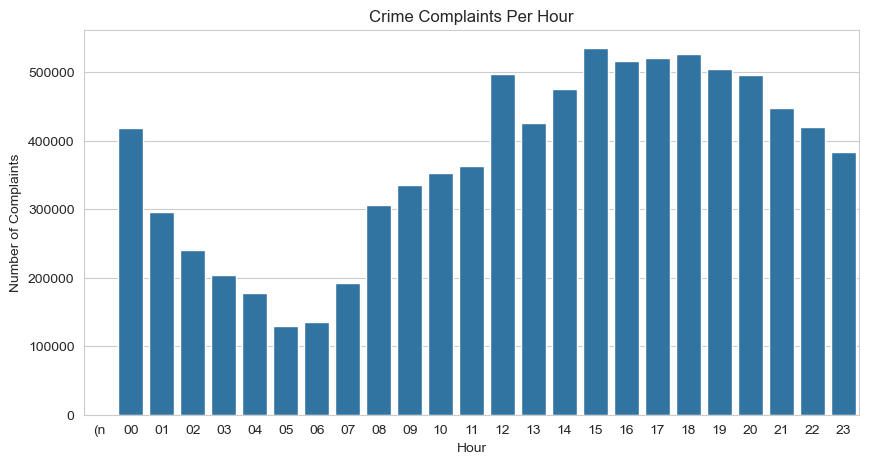

In [35]:
# Plot bar chart of number of complaints per hour

x = data['Hour'].value_counts().index
y = data['Hour'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y, order=x.sort_values())
ax.set_title('Crime Complaints Per Hour')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

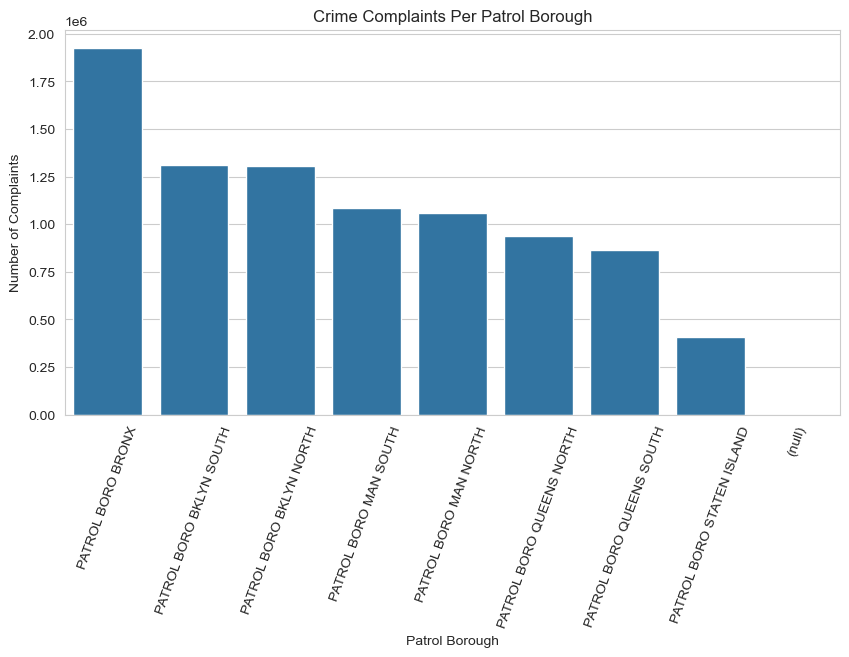

In [36]:
# Plot bar chart of number of complaints per patrol borough

x = data['PATROL_BORO'].value_counts().index
y = data['PATROL_BORO'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Patrol Borough')
plt.xticks(rotation=70)
ax.set_xlabel('Patrol Borough')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

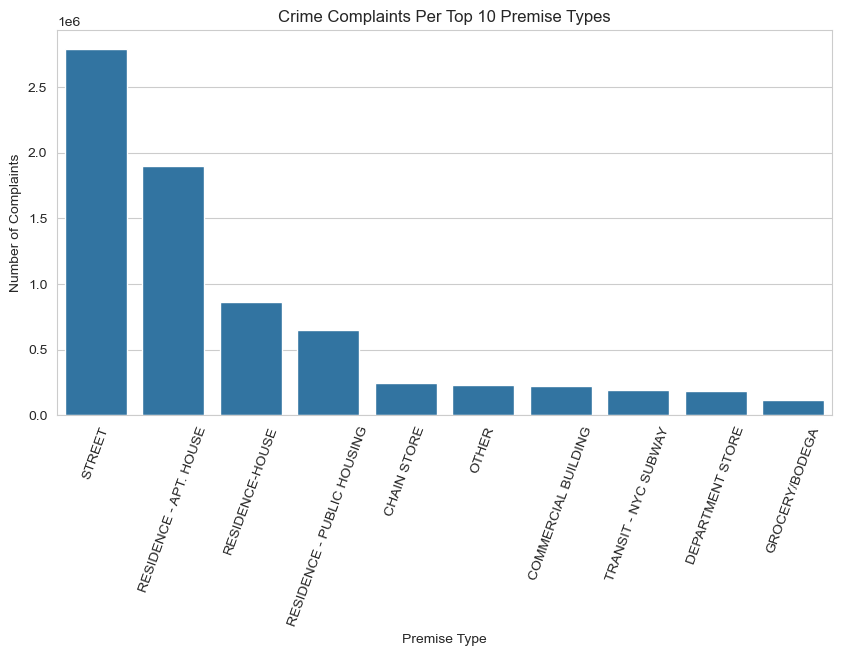

In [37]:
# Plot bar chart of number of complaints per premise type description

x = data['PREM_TYP_DESC'].value_counts().index[:10]
y = data['PREM_TYP_DESC'].value_counts().values[:10]

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Top 10 Premise Types')
plt.xticks(rotation=70)
ax.set_xlabel('Premise Type')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

In [91]:
data['SUSP_AGE_GROUP'].value_counts()

SUSP_AGE_GROUP
(null)     4568089
25-44      1624797
UNKNOWN    1273519
18-24       605115
45-64       565810
            ...   
1953             1
4646             1
1515             1
292              1
-956             1
Name: count, Length: 274, dtype: int64

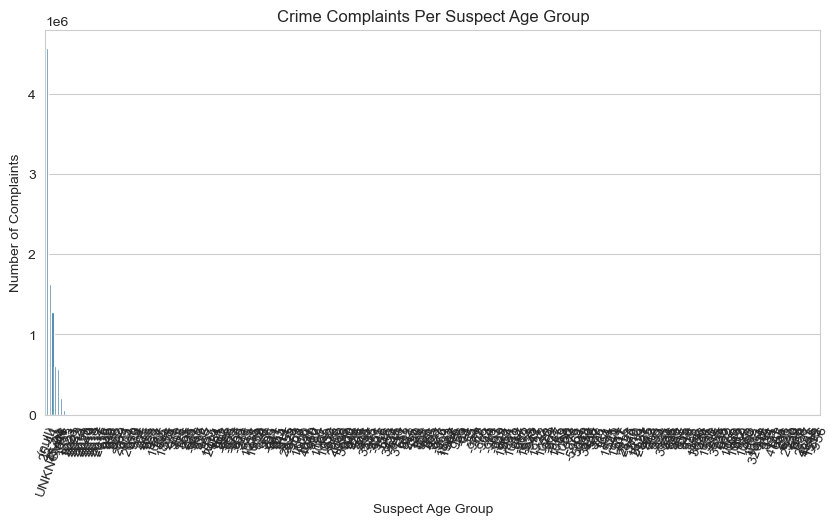

In [38]:
# Plot bar chart of number of complaints per suspect age group

x = data['SUSP_AGE_GROUP'].value_counts().index
y = data['SUSP_AGE_GROUP'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Suspect Age Group')
plt.xticks(rotation=70)
ax.set_xlabel('Suspect Age Group')
ax.set_ylabel('Number of Complaints');

In [39]:
data['SUSP_AGE_GROUP'].value_counts()

SUSP_AGE_GROUP
(null)     4568089
25-44      1624797
UNKNOWN    1273519
18-24       605115
45-64       565810
            ...   
1953             1
4646             1
1515             1
292              1
-956             1
Name: count, Length: 274, dtype: int64

##TO DO
Add summary of above bar plot

NOT USEFUL

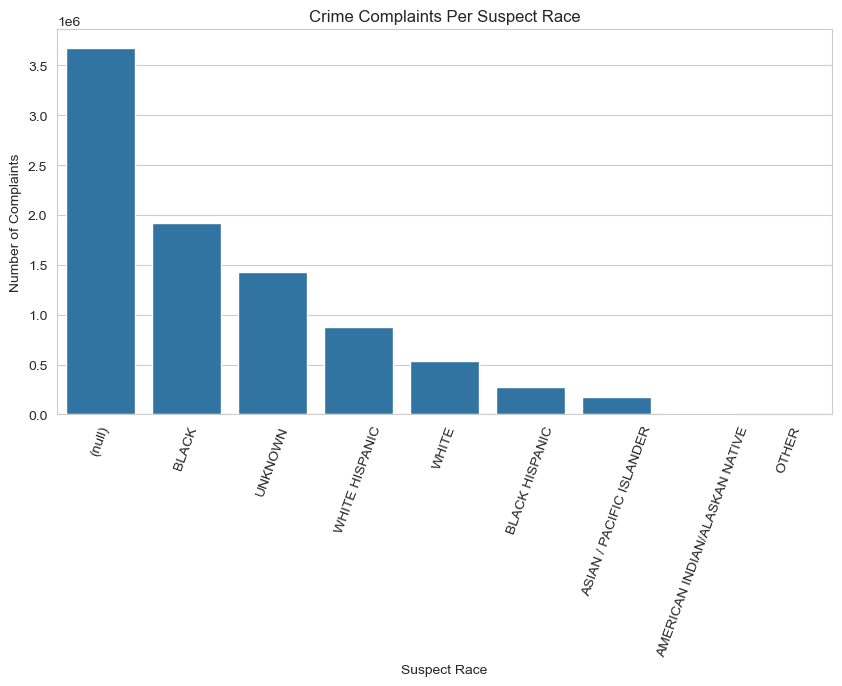

In [40]:
# Plot bar chart of number of complaints per suspect race

x = data['SUSP_RACE'].value_counts().index
y = data['SUSP_RACE'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Suspect Race')
plt.xticks(rotation=70)
ax.set_xlabel('Suspect Race')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

This would also have to be compared to the demographics of New Yorkers in all 5 boroughs

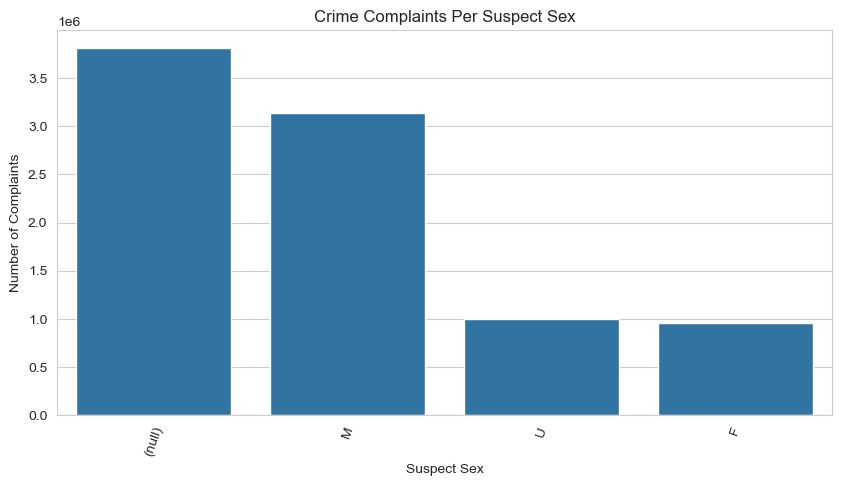

In [41]:
# Plot bar chart of number of complaints per suspect sex

x = data['SUSP_SEX'].value_counts().index
y = data['SUSP_SEX'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Suspect Sex')
plt.xticks(rotation=70)
ax.set_xlabel('Suspect Sex')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

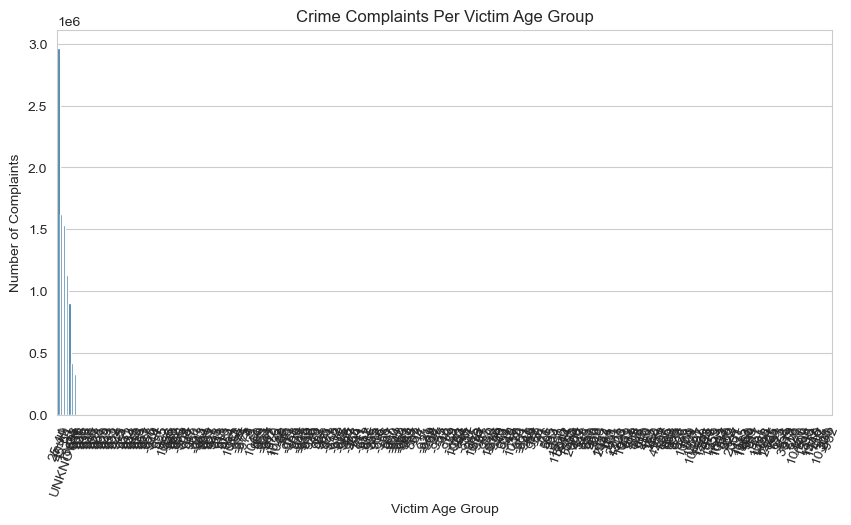

In [42]:
# Plot bar chart of number of complaints per victim age group

x = data['VIC_AGE_GROUP'].value_counts().index
y = data['VIC_AGE_GROUP'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Victim Age Group')
plt.xticks(rotation=70)
ax.set_xlabel('Victim Age Group')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

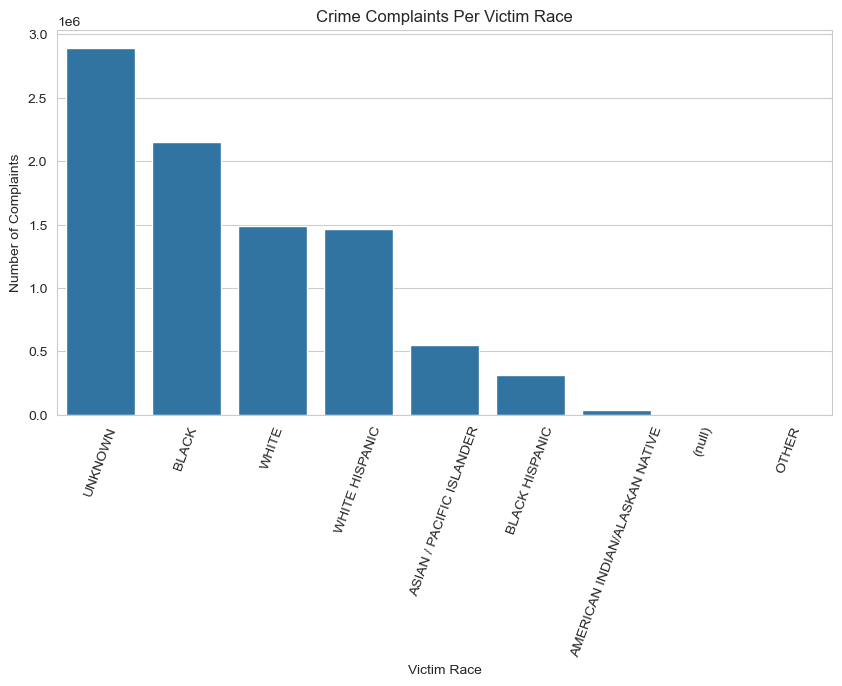

In [43]:
# Plot bar chart of number of complaints per victim race

x = data['VIC_RACE'].value_counts().index
y = data['VIC_RACE'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Victim Race')
plt.xticks(rotation=70)
ax.set_xlabel('Victim Race')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

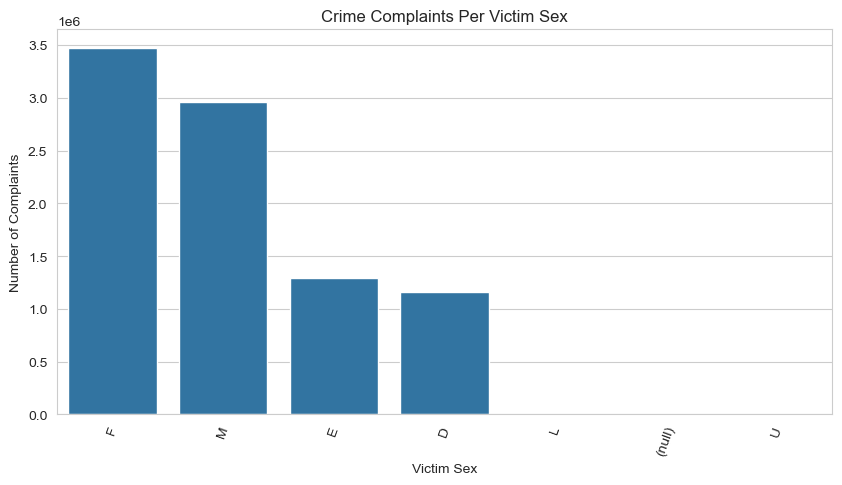

In [44]:
# Plot bar chart of number of complaints per victim sex

x = data['VIC_SEX'].value_counts().index
y = data['VIC_SEX'].value_counts().values

fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(x=x, y=y)
ax.set_title('Crime Complaints Per Victim Sex')
plt.xticks(rotation=70)
ax.set_xlabel('Victim Sex')
ax.set_ylabel('Number of Complaints');

##TO DO
Add summary of above bar plot

NOT USEFUL DUE TO NULL

In [45]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8893453 entries, 2006-01-01 to 2023-12-31
Data columns (total 39 columns):
 #   Column             Dtype         
---  ------             -----         
 0   CMPLNT_NUM         object        
 1   CMPLNT_FR_DT       datetime64[ns]
 2   CMPLNT_FR_TM       object        
 3   CMPLNT_TO_DT       object        
 4   CMPLNT_TO_TM       object        
 5   ADDR_PCT_CD        float64       
 6   RPT_DT             object        
 7   KY_CD              int64         
 8   OFNS_DESC          object        
 9   PD_CD              float64       
 10  PD_DESC            object        
 11  CRM_ATPT_CPTD_CD   object        
 12  LAW_CAT_CD         object        
 13  BORO_NM            object        
 14  LOC_OF_OCCUR_DESC  object        
 15  PREM_TYP_DESC      object        
 16  JURIS_DESC         object        
 17  JURISDICTION_CODE  int64         
 18  PARKS_NM           object        
 19  HADEVELOPT         object        
 20  HOUSING_P

## Data Preparation

In [46]:
print(data_weekly.head(15), data_weekly.tail(15))

CMPLNT_FR_DT
2006-01-01     2179
2006-01-08     9839
2006-01-15    10084
2006-01-22     9760
2006-01-29     9689
2006-02-05     9946
2006-02-12     9038
2006-02-19     9252
2006-02-26     8819
2006-03-05     9615
2006-03-12    10039
2006-03-19     9919
2006-03-26     9830
2006-04-02    10199
2006-04-09     9912
Freq: W-SUN, Name: CMPLNT_FR_DT, dtype: int64 CMPLNT_FR_DT
2023-09-24     9932
2023-10-01    10241
2023-10-08    11111
2023-10-15    10499
2023-10-22    10628
2023-10-29    10832
2023-11-05    10619
2023-11-12    10535
2023-11-19    10516
2023-11-26     9435
2023-12-03    10186
2023-12-10    10065
2023-12-17     9812
2023-12-24     9284
2023-12-31     8050
Freq: W-SUN, Name: CMPLNT_FR_DT, dtype: int64


According to the graph and the list of the first 15 datapoints in `data_sample_weekly`, the beginning of the data is not reliable. There are many missing datapoints. The description of the data states that it begins in the year 2006, so I will remove all datapoints before that year.

In [47]:
# Remove any entries before year 2006
data_weekly = data_weekly[data_weekly.index>'2006-01-01']

In [48]:
# Check if any weeks have 0 complaints
data_weekly.value_counts()

CMPLNT_FR_DT
8319     3
10200    3
10303    3
10280    3
10046    3
        ..
10324    1
9964     1
10020    1
9998     1
9284     1
Name: count, Length: 817, dtype: int64

In [49]:
data_weekly

CMPLNT_FR_DT
2006-01-08     9839
2006-01-15    10084
2006-01-22     9760
2006-01-29     9689
2006-02-05     9946
              ...  
2023-12-03    10186
2023-12-10    10065
2023-12-17     9812
2023-12-24     9284
2023-12-31     8050
Freq: W-SUN, Name: CMPLNT_FR_DT, Length: 939, dtype: int64

In [50]:
# Look at which weeks have 0 complaints
data_weekly[data_weekly==0]

Series([], Freq: W-SUN, Name: CMPLNT_FR_DT, dtype: int64)

I wondered if it was possible for these 5 weeks to have 0 crime complaints. The answer is no due to a quick Google search. On the night of April 4th, 2010, [54 people were shot and 4 were arrested](https://nypost.com/2010/04/05/54-arrested-4-shot-in-times-square-riot/) in a riot in Times Square according to the NY Post. According to CNN, there were multiple crime incidents the week of August 16, 2020, with [20 victims as a result of 12 shooting incidents on [8/14/2020], and 23 victims as a result of 20 shooting incidents on [8/15/2020]](https://www.cnn.com/2020/08/16/us/nyc-chicago-gun-violence/index.html). When data is resampled weekly, the date listed is the end of the week.

This demonstrated that not all crime complaints are listed in this data, and 0 complaints does not necessarily mean there was no crime that week. There are gaps in the data that need to be addressed. 

## Feature Engineering

## Train Test Split (Edit title name)

In [51]:
# Find the index which allows us to split off 20% of the data
cutoff = round(data_weekly.shape[0]*0.8)
cutoff

751

In [52]:
# Define train and test sets according to cutoff index above
train = data_weekly[:cutoff]

test = data_weekly[cutoff:]

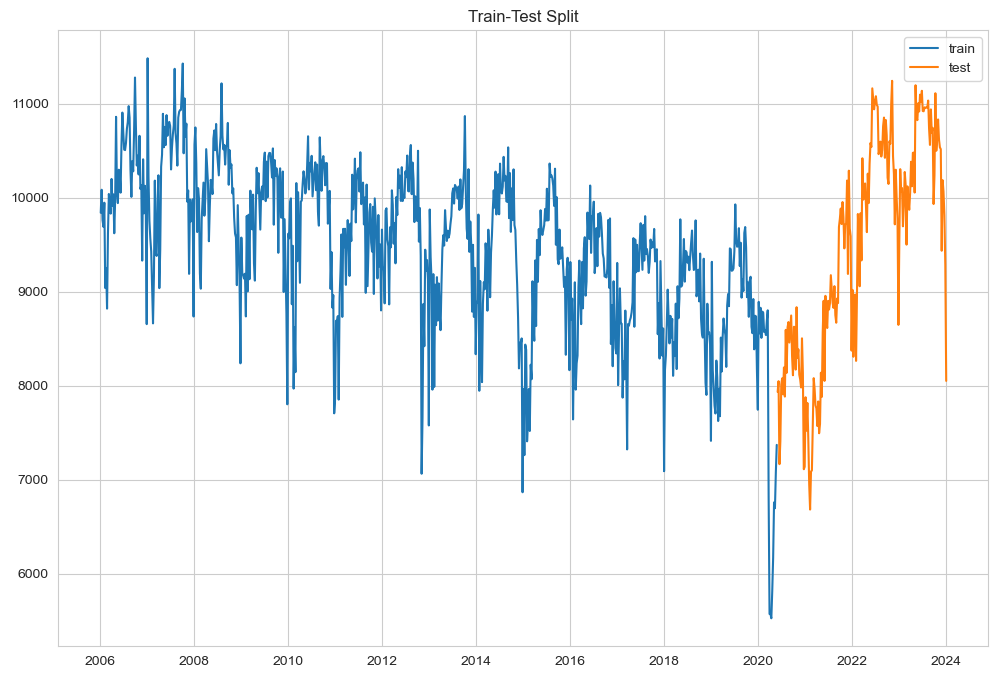

In [53]:
# Plot time series with cutoff highlighted
fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(train, label='train')
ax.plot(test, label='test')
ax.set_title('Train-Test Split');
plt.legend();

In [54]:
# Complete a train test split with TimeSeriesSplit
split = TimeSeriesSplit()

for train_ind, val_ind in split.split(train):
    print(f'Train index: {train_ind}')
    print(f'Test  index: {val_ind}')

Train index: [  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125]
Test  index: [126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239

# Modeling

In [55]:
def display_df(dftest):
    '''
    Display the output from a Dickey-Fuller test in a more readable format
    '''
    
    
    dfoutput = pd.Series(
                dftest[0:4], 
                index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value

    display(dfoutput)
    
    print(f"The p-value associated with the Dickey-Fuller statistical test is {dfoutput['p-value']},")
    if dfoutput['p-value'] < 0.05:
        print(" so we can safely assume that the differenced data is stationary.")
    else:
        print(" so we cannot reject the null hypothesis that the differenced data is \
    not stationary.")

## Baseline Model

In [56]:
# Create baseline model with shift operator
naive = train.shift(1)
naive

CMPLNT_FR_DT
2006-01-08        NaN
2006-01-15     9839.0
2006-01-22    10084.0
2006-01-29     9760.0
2006-02-05     9689.0
               ...   
2020-04-26     5812.0
2020-05-03     6167.0
2020-05-10     6757.0
2020-05-17     6695.0
2020-05-24     7078.0
Freq: W-SUN, Name: CMPLNT_FR_DT, Length: 751, dtype: float64

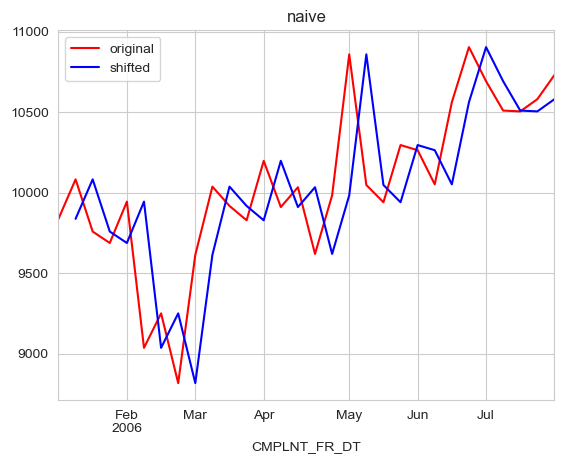

In [57]:
# Plot baseline model
fig, ax = plt.subplots()

train[0:30].plot(ax=ax, c='r', label='original')
naive[0:30].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

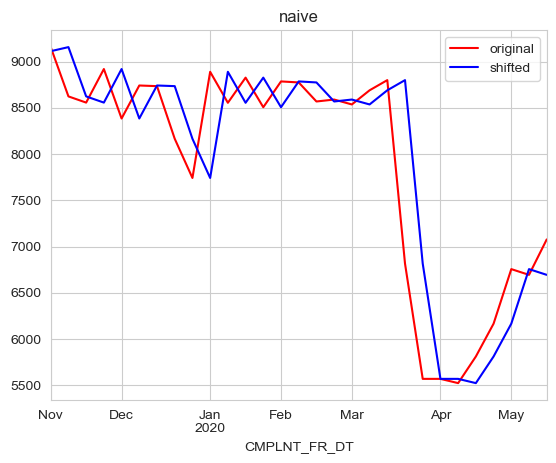

In [58]:
# Plot baseline model
fig, ax = plt.subplots()

train[-30:-1].plot(ax=ax, c='r', label='original')
naive[-30:-1].plot(ax=ax, c='b', label='shifted')
ax.set_title('naive')
ax.legend();

In [59]:
# Calculate RMSE for baseline model
np.sqrt(mean_squared_error(train[1:], naive.dropna()))

551.3558101020913

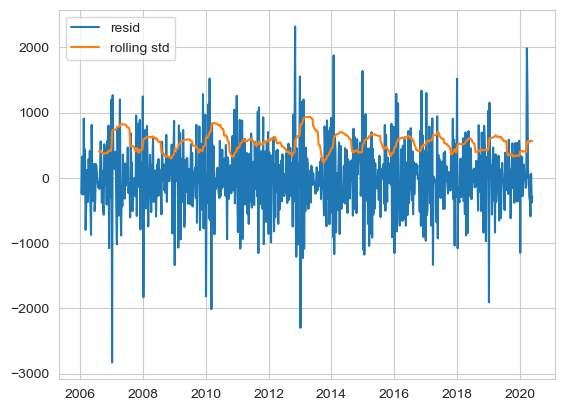

In [60]:
# 
fig, ax = plt.subplots()
residuals = naive[1:] - train[1:]
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).std(), label='rolling std')
ax.legend();

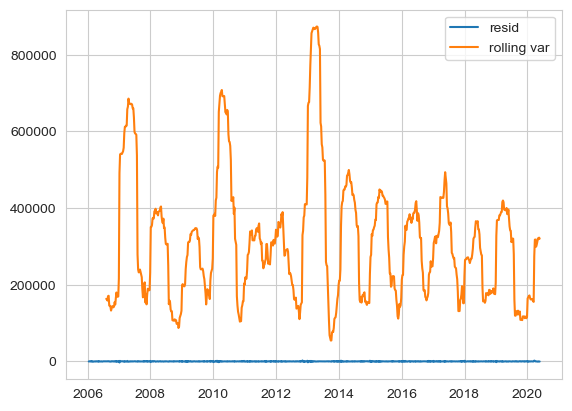

In [61]:
# 
fig, ax = plt.subplots()
ax.plot(residuals.index, residuals, label='resid')
ax.plot(residuals.index, residuals.rolling(30).var(), label='rolling var')
ax.legend();

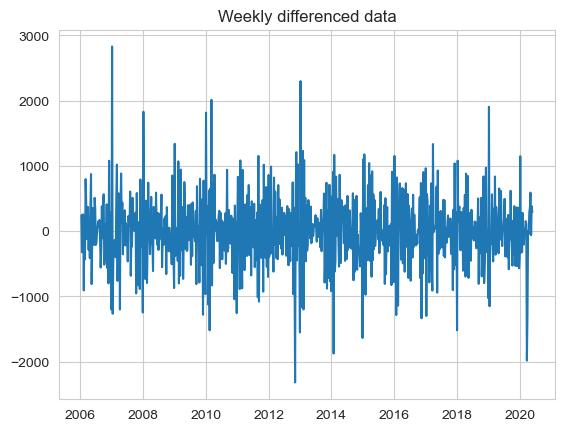

In [62]:
# Visualize differenced data
fig, ax = plt.subplots()
ax.plot(train.diff())
ax.set_title('Weekly differenced data');

In [63]:
dftest = adfuller(test.diff()[1:])
display_df(dftest)

Test Statistic                  -3.817145
p-value                          0.002737
#Lags Used                       8.000000
Number of Observations Used    178.000000
Critical Value (1%)             -3.467632
Critical Value (5%)             -2.877918
Critical Value (10%)            -2.575501
dtype: float64

The p-value associated with the Dickey-Fuller statistical test is 0.0027366897732197188,
 so we can safely assume that the differenced data is stationary.


## Model Iterations

### Arima Model

In [64]:
# ar_1 model with differencing
ar_1 = ARIMA(train, order=(1, 1, 0)).fit()

# We put a typ='levels' to convert our predictions to remove the differencing performed.
ar_1.predict(typ='levels')

CMPLNT_FR_DT
2006-01-08       0.000000
2006-01-15    8794.814883
2006-01-22    9971.248064
2006-01-29    9909.108682
2006-02-05    9721.675051
                 ...     
2020-04-26    5679.458949
2020-05-03    6003.624746
2020-05-10    6485.474931
2020-05-17    6723.533143
2020-05-24    6901.738811
Freq: W-SUN, Name: predicted_mean, Length: 751, dtype: float64

In [65]:
# Summary
ar_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CMPLNT_FR_DT   No. Observations:                  751
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -5706.522
Date:                Sun, 19 Jan 2025   AIC                          11417.045
Time:                        00:17:07   BIC                          11426.285
Sample:                    01-08-2006   HQIC                         11420.605
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4602      0.024    -18.981      0.000      -0.508      -0.413
sigma2      2.362e+05   7956.642     29.691      0.000    2.21e+05    2.52e+05
===================================================================================
Ljung-Box (L1) (Q):                   4.99   Jarque-Bera (JB):               229.91
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                            -0.28
Prob(H) (two-sided):                  0.31   Kurtosis:                         5.65
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [66]:
# Random walk
random_walk_model = ARIMA(train, order=(0, 1, 0)).fit()
random_walk_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CMPLNT_FR_DT   No. Observations:                  751
Model:                 ARIMA(0, 1, 0)   Log Likelihood               -5798.489
Date:                Sun, 19 Jan 2025   AIC                          11598.979
Time:                        00:17:07   BIC                          11603.599
Sample:                    01-08-2006   HQIC                         11600.759
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2      3.036e+05   1.09e+04     27.844      0.000    2.82e+05    3.25e+05
===================================================================================
Ljung-Box (L1) (Q):                 168.38   Jarque-Bera (JB):               144.35
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.88   Skew:                             0.15
Prob(H) (two-sided):                  0.32   Kurtosis:                         5.13
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [67]:
# Baseline ARIMA model
baseline = ARIMA(train, order=(0,0,0)).fit()
bl_preds = baseline.predict(typ='levels')
bl_rmse = np.sqrt(mean_squared_error(train, bl_preds))

In [68]:
print(f'Baseline AIC: {baseline.aic}')
print(f'Random Walk AIC: {random_walk_model.aic}')
print(f'AR(1, 1, 0) AIC: {ar_1.aic}' )

Baseline AIC: 12288.748443241773
Random Walk AIC: 11598.978997039558
AR(1, 1, 0) AIC: 11417.044502407276


In [69]:
y_hat_ar1 = ar_1.predict(typ='levels')
ar1_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [70]:
y_hat_rw = random_walk_model.predict(typ='levels')
rw_rmse = np.sqrt(mean_squared_error(train, y_hat_rw))

In [71]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')

Baseline RMSE:    862.6316715862915
Random Walk RMSE: 657.6405825516763
AR1 RMSE:         605.6227432134734


The baseline ARIMA model has the best AIC and the best RMSE.

### Adding A Term

In [72]:
ar_2 = ARIMA(train, order=(2, 1, 0)).fit()

ar_2.predict(typ='levels')

CMPLNT_FR_DT
2006-01-08       0.000000
2006-01-15    8784.696710
2006-01-22    9692.133359
2006-01-29    9896.187007
2006-02-05    9774.097559
                 ...     
2020-04-26    5665.814559
2020-05-03    5936.377865
2020-05-10    6391.801642
2020-05-17    6641.604840
2020-05-24    6883.714565
Freq: W-SUN, Name: predicted_mean, Length: 751, dtype: float64

In [73]:
print(baseline.aic)
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)

12288.748443241773
11598.978997039558
11417.044502407276
11402.404755399224


In [74]:
y_hat_ar1 = ar_2.predict(typ='levels')
ar2_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [75]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')
print(f'AR2 RMSE:         {ar2_rmse}')

Baseline RMSE:    862.6316715862915
Random Walk RMSE: 657.6405825516763
AR1 RMSE:         605.6227432134734
AR2 RMSE:         601.3379509149315


### Moving Average Model

In [76]:
ma_1 = ARIMA(train, order=(0, 0, 1)).fit()
y_hat = ma_1.predict(typ='levels')
y_hat

CMPLNT_FR_DT
2006-01-08    9469.119742
2006-01-15    9619.634436
2006-01-22    9695.583406
2006-01-29    9501.822635
2006-02-05    9565.120042
                 ...     
2020-04-26    8286.164425
2020-05-03    8378.276474
2020-05-10    8634.565091
2020-05-17    8470.725518
2020-05-24    8752.212060
Freq: W-SUN, Name: predicted_mean, Length: 751, dtype: float64

In [77]:
ma_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:           CMPLNT_FR_DT   No. Observations:                  751
Model:                 ARIMA(0, 0, 1)   Log Likelihood               -5971.483
Date:                Sun, 19 Jan 2025   AIC                          11948.966
Time:                        00:17:07   BIC                          11962.831
Sample:                    01-08-2006   HQIC                         11954.308
                         - 05-24-2020                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       9469.1197     42.183    224.476      0.000    9386.442    9551.797
ma.L1          0.5148      0.028     18.440      0.000       0.460       0.569
sigma2      4.719e+05   2.25e+04     20.928      0.000    4.28e+05    5.16e+05
===================================================================================
Ljung-Box (L1) (Q):                  69.87   Jarque-Bera (JB):               108.28
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.19   Skew:                            -0.76
Prob(H) (two-sided):                  0.17   Kurtosis:                         4.07
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [78]:
ma_1 = ARIMA(train, order=(0, 1, 1)).fit()
print(baseline.aic)
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)

12288.748443241773
11598.978997039558
11417.044502407276
11402.404755399224
11387.036071904047


In [79]:
y_hat_ar1 = ma_1.predict(typ='levels')
ma1_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [80]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')
print(f'AR2 RMSE:         {ar2_rmse}')
print(f'MA1 RMSE:         {ma1_rmse}')

Baseline RMSE:    862.6316715862915
Random Walk RMSE: 657.6405825516763
AR1 RMSE:         605.6227432134734
AR2 RMSE:         601.3379509149315
MA1 RMSE:         597.849471763283


In [81]:
# MA 2 lag past 2 terms
ma_2 = ARIMA(train, order=(0, 1, 2)).fit()
y_hat = ma_2.predict(typ='levels')
y_hat

CMPLNT_FR_DT
2006-01-08       0.000000
2006-01-15    8819.495422
2006-01-22    9565.970757
2006-01-29    9694.395266
2006-02-05    9699.374008
                 ...     
2020-04-26    5806.532477
2020-05-03    5961.039000
2020-05-10    6319.769345
2020-05-17    6513.790176
2020-05-24    6772.836298
Freq: W-SUN, Name: predicted_mean, Length: 751, dtype: float64

In [82]:
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)

11598.978997039558
11417.044502407276
11402.404755399224
11387.036071904047
11387.53574970341


In [83]:
y_hat_ar1 = ma_2.predict(typ='levels')
ma2_rmse = np.sqrt(mean_squared_error(train, y_hat_ar1))

In [84]:
print(f'Baseline RMSE:    {bl_rmse}')
print(f'Random Walk RMSE: {rw_rmse}')
print(f'AR1 RMSE:         {ar1_rmse}')
print(f'AR2 RMSE:         {ar2_rmse}')
print(f'MA1 RMSE:         {ma1_rmse}')
print(f'MA2 RMSE:         {ma2_rmse}')

Baseline RMSE:    862.6316715862915
Random Walk RMSE: 657.6405825516763
AR1 RMSE:         605.6227432134734
AR2 RMSE:         601.3379509149315
MA1 RMSE:         597.849471763283
MA2 RMSE:         597.5319404931349


### ARMA

In [85]:
arma_21 = ARIMA(train, order=(2, 1, 2)).fit()

In [86]:
print(baseline.aic)
print(random_walk_model.aic)
print(ar_1.aic)
print(ar_2.aic)
print(ma_1.aic)
print(ma_2.aic)
print(arma_21.aic)

12288.748443241773
11598.978997039558
11417.044502407276
11402.404755399224
11387.036071904047
11387.53574970341
11386.526022418886


In [87]:
def find_rmse(model, train_data=train):
    y_hat = model.predict(typ='levels')
    return np.sqrt(mean_squared_error(train_data, y_hat))

In [88]:
print(find_rmse(baseline))
print(find_rmse(random_walk_model))
print(find_rmse(ar_1))
print(find_rmse(ar_2))
print(find_rmse(ma_1))
print(find_rmse(ma_2))
print(find_rmse(arma_21))

862.6316715862915
657.6405825516763
605.6227432134734
601.3379509149315
597.849471763283
597.5319404931349
596.2893330113083


### Test data

In [89]:
def find_rmse_test(model, test_data=test):
    y_hat = model.predict(start=test_data.index[0], end=test_data.index[-1], typ='levels')
    return np.sqrt(mean_squared_error(test_data, y_hat))

In [90]:
print(find_rmse_test(baseline))
print(find_rmse_test(random_walk_model))
print(find_rmse_test(ar_1))
print(find_rmse_test(ar_2))
print(find_rmse_test(ma_1))
print(find_rmse_test(ma_2))
print(find_rmse_test(arma_21))

1175.18453943942
2404.794617894701
2485.2436062460347
2537.6047167844936
2698.8301555667026
2663.4669173407797
2695.245555577047


/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)
/Users/scarlettvalentin/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/statespace/representation.py:374: Futur

## Final Model

# Conclusion

## Limitations

1. **Major changes in administrations** can have a great effect on future crime. This analysis and model does not account for that. Mayor Eric Adams has appointed a new New York City Police Commissioner in November 2024 (Jessica Tisch) and President Donald Trump has taken office in January 2025.
2. The date and time of the occurence of the crime is based on when it was reported to occur. Since the complaint may not be reported at the exact time of occurence, the **dates and times may not all be completely accurate**.
3. Crime complaints which involve multiple offenses are classified according to the most serious offense. Therefore, 

## Next Steps

## 